In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

import re
from tqdm.auto import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
root_dir = '/content/drive/MyDrive/Финальный проект/'
train = pd.read_csv(root_dir + 'train.tsv', sep='\t', header=0)
test = pd.read_csv(root_dir + 'test.tsv', sep='\t', header=0)
train.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


# Препроцессинг

In [3]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [4]:
lemmatizer = WordNetLemmatizer()

class TextPreprocessor:
  def __call__(self, text):
        lowercase_text = text.lower()
        raw_tokens = nltk.word_tokenize(lowercase_text)
        lemmatized_tokens = [
              lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in raw_tokens
        ]
        clean_tokens = [
            re.sub('[^a-z]', '', token) for token in lemmatized_tokens
        ]
        stopwords = set(nltk.corpus.stopwords.words('english'))
        clean_tokens = [token for token in clean_tokens if token and token not in stopwords]
        return [
            token for token in clean_tokens if token not in stopwords
        ]

In [5]:
train["Phrase"] = [TextPreprocessor()(x) for x in tqdm(train["Phrase"])]
train.to_csv(root_dir + 'clean_train.csv')
test["Phrase"] = [TextPreprocessor()(x) for x in tqdm(test["Phrase"])]
test.to_csv(root_dir + 'clean_test.csv')

In [6]:
print('До препроцессинга:\n' + train["Phrase"][0])
print('После: \n' + TextPreprocessor()(train["Phrase"][0]))

До препроцессинга:
series escapade demonstrate adage good goose also good gander occasionally amuses none amount much story
После: 
series escapade demonstrate adage good goose also good gander occasionally amuses none amount much story


Text(0.5, 1.0, 'Распределение целевой переменной')

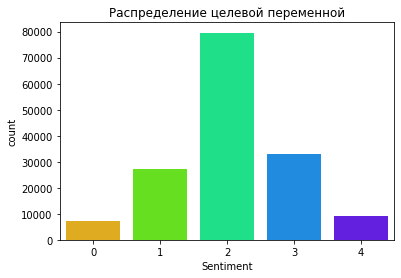

In [7]:
sns.countplot(x=train.Sentiment, palette='gist_rainbow').set_title("Распределение целевой переменной")

In [8]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train.Phrase.values)
y = train.Sentiment.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=21)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Распределение целевой переменной на тренировочной выборке')

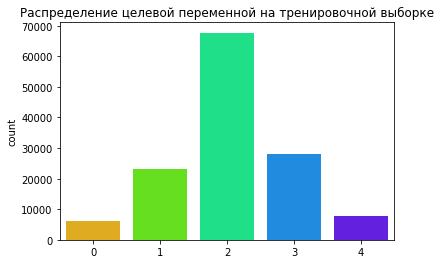

In [9]:
sns.countplot(y_train, palette='gist_rainbow').set_title("Распределение целевой переменной на тренировочной выборке")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Распределение целевой переменной на валидационной выборке')

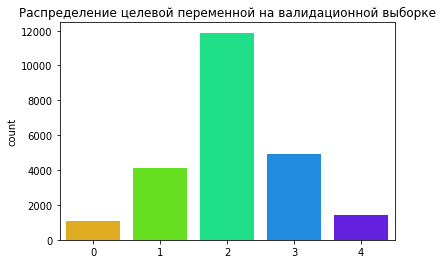

In [10]:
sns.countplot(y_val, palette='gist_rainbow').set_title("Распределение целевой переменной на валидационной выборке")

# Обучение методов ML на неизмененном датасете(с несбалансированными классами)

In [11]:
logreg = LogisticRegression(multi_class="multinomial", random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.29      0.38      1084
           1       0.54      0.39      0.45      4107
           2       0.69      0.87      0.77     11877
           3       0.58      0.47      0.52      4926
           4       0.61      0.34      0.44      1415

    accuracy                           0.64     23409
   macro avg       0.59      0.47      0.51     23409
weighted avg       0.63      0.64      0.62     23409



In [12]:
gb_cls = GradientBoostingClassifier(random_state=42)
gb_cls.fit(X_train, y_train)
y_pred = gb_cls.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.09      0.15      1084
           1       0.46      0.05      0.09      4107
           2       0.53      0.98      0.69     11877
           3       0.50      0.08      0.14      4926
           4       0.72      0.09      0.16      1415

    accuracy                           0.53     23409
   macro avg       0.58      0.26      0.25     23409
weighted avg       0.53      0.53      0.41     23409



In [13]:
tree = DecisionTreeClassifier(random_state=42, max_depth=7, criterion='entropy')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.00      0.01      1084
           1       0.36      0.07      0.12      4107
           2       0.52      0.97      0.68     11877
           3       0.43      0.04      0.07      4926
           4       0.41      0.07      0.13      1415

    accuracy                           0.52     23409
   macro avg       0.41      0.23      0.20     23409
weighted avg       0.46      0.52      0.39     23409



In [14]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.29      0.36      1084
           1       0.50      0.40      0.44      4107
           2       0.68      0.80      0.74     11877
           3       0.53      0.49      0.51      4926
           4       0.51      0.31      0.38      1415

    accuracy                           0.61     23409
   macro avg       0.54      0.46      0.49     23409
weighted avg       0.60      0.61      0.60     23409



# Обучение на тренировочной выборке без дубликатов

In [15]:
without_dups = train.drop_duplicates(subset=['Phrase', 'Sentiment'])
X = vectorizer.fit_transform(without_dups.Phrase.values)
y = without_dups.Sentiment.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=21)

In [16]:
logreg = LogisticRegression(multi_class="multinomial", random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.17      0.24       824
           1       0.43      0.31      0.36      2897
           2       0.59      0.80      0.68      7020
           3       0.48      0.38      0.42      3518
           4       0.44      0.22      0.29      1051

    accuracy                           0.54     15310
   macro avg       0.47      0.38      0.40     15310
weighted avg       0.51      0.54      0.51     15310



In [17]:
gb_cls = GradientBoostingClassifier(random_state=42)
gb_cls.fit(X_train, y_train)
y_pred = gb_cls.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.06      0.11       824
           1       0.42      0.05      0.10      2897
           2       0.48      0.97      0.64      7020
           3       0.42      0.07      0.12      3518
           4       0.55      0.07      0.12      1051

    accuracy                           0.48     15310
   macro avg       0.48      0.25      0.22     15310
weighted avg       0.46      0.48      0.36     15310



In [18]:
tree = DecisionTreeClassifier(random_state=42, max_depth=7, criterion='entropy')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.01      0.02       824
           1       0.35      0.06      0.11      2897
           2       0.47      0.97      0.64      7020
           3       0.41      0.04      0.08      3518
           4       0.50      0.01      0.03      1051

    accuracy                           0.47     15310
   macro avg       0.43      0.22      0.17     15310
weighted avg       0.43      0.47      0.33     15310



In [19]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.19      0.26       824
           1       0.41      0.37      0.39      2897
           2       0.59      0.70      0.64      7020
           3       0.45      0.43      0.44      3518
           4       0.38      0.21      0.27      1051

    accuracy                           0.52     15310
   macro avg       0.44      0.38      0.40     15310
weighted avg       0.50      0.52      0.50     15310



# TFidf

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

TFvectorizer = TfidfVectorizer()
X = TFvectorizer.fit_transform(train.Phrase.values)
y = train.Sentiment.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=21)

In [21]:
logreg = LogisticRegression(multi_class="multinomial", random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.19      0.29      1084
           1       0.53      0.36      0.43      4107
           2       0.67      0.88      0.76     11877
           3       0.56      0.48      0.52      4926
           4       0.65      0.27      0.38      1415

    accuracy                           0.63     23409
   macro avg       0.61      0.44      0.48     23409
weighted avg       0.62      0.63      0.61     23409



In [22]:
gb_cls = GradientBoostingClassifier(random_state=42)
gb_cls.fit(X_train, y_train)
y_pred = gb_cls.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.10      0.17      1084
           1       0.45      0.06      0.10      4107
           2       0.54      0.98      0.69     11877
           3       0.50      0.09      0.16      4926
           4       0.73      0.09      0.16      1415

    accuracy                           0.53     23409
   macro avg       0.57      0.26      0.25     23409
weighted avg       0.53      0.53      0.42     23409



In [23]:
tree = DecisionTreeClassifier(random_state=42, max_depth=7, criterion='entropy')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1084
           1       0.37      0.07      0.11      4107
           2       0.53      0.96      0.68     11877
           3       0.34      0.08      0.13      4926
           4       0.41      0.07      0.12      1415

    accuracy                           0.52     23409
   macro avg       0.33      0.23      0.21     23409
weighted avg       0.43      0.52      0.40     23409



In [24]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.05      0.10      1084
           1       0.52      0.27      0.35      4107
           2       0.61      0.90      0.73     11877
           3       0.53      0.39      0.45      4926
           4       0.60      0.06      0.11      1415

    accuracy                           0.59     23409
   macro avg       0.57      0.33      0.35     23409
weighted avg       0.58      0.59      0.54     23409



# 3 лейбла вместо 5

In [25]:
new_train = train.copy()
new_train.loc[new_train.Sentiment == 1, 'Sentiment'] = 0
new_train.loc[new_train.Sentiment == 3, 'Sentiment'] = 4
new_train.Sentiment.unique()

array([0, 2, 4])

Text(0.5, 1.0, 'Распределение целевой переменной')

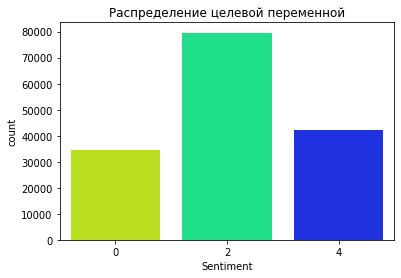

In [26]:
sns.countplot(x=new_train.Sentiment, palette='gist_rainbow').set_title("Распределение целевой переменной")

In [27]:
new_train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,series escapade demonstrate adage good goose a...,0
1,2,1,series escapade demonstrate adage good goose,2
2,3,1,series,2
3,4,1,,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,hearst,2
156056,156057,8544,force avuncular chortle,0
156057,156058,8544,avuncular chortle,4
156058,156059,8544,avuncular,2


In [28]:
X = vectorizer.fit_transform(new_train.Phrase.values)
y = new_train.Sentiment.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=21)

logreg = LogisticRegression(multi_class="multinomial", random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.56      0.64      5191
           2       0.71      0.85      0.77     11877
           4       0.78      0.65      0.71      6341

    accuracy                           0.73     23409
   macro avg       0.74      0.69      0.71     23409
weighted avg       0.74      0.73      0.73     23409



In [29]:
gb_cls = GradientBoostingClassifier(random_state=42)
gb_cls.fit(X_train, y_train)
y_pred = gb_cls.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.13      0.22      5191
           2       0.56      0.96      0.70     11877
           4       0.74      0.24      0.36      6341

    accuracy                           0.58     23409
   macro avg       0.67      0.44      0.43     23409
weighted avg       0.64      0.58      0.50     23409



In [30]:
tree = DecisionTreeClassifier(random_state=42, max_depth=7, criterion='entropy')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.09      0.15      5191
           2       0.53      0.94      0.68     11877
           4       0.50      0.13      0.21      6341

    accuracy                           0.53     23409
   macro avg       0.52      0.39      0.35     23409
weighted avg       0.53      0.53      0.43     23409



In [31]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.58      0.61      5191
           2       0.70      0.75      0.73     11877
           4       0.69      0.66      0.67      6341

    accuracy                           0.69     23409
   macro avg       0.68      0.66      0.67     23409
weighted avg       0.69      0.69      0.69     23409



# Add more data

In [32]:
more_train_data = pd.read_csv(root_dir + 'labeledTrainData.tsv', header=0, sep='\t')
more_train_data["review"] = [TextPreprocessor()(x) for x in tqdm(more_train_data["review"])]

In [33]:
more_train_data.rename(columns={"review": "Phrase", "sentiment": "Sentiment"}, inplace=True)
more_train_data.loc[more_train_data.Sentiment == 1, 'Sentiment'] = 4
add_data = pd.concat([more_train_data, train])

Text(0.5, 1.0, 'Распределение целевой переменной')

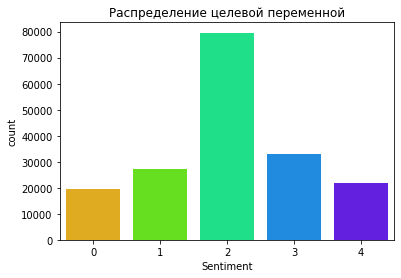

In [35]:
sns.countplot(x=add_data.Sentiment, palette='gist_rainbow').set_title("Распределение целевой переменной")

In [36]:
add_data

,id,Sentiment,Phrase,PhraseId,SentenceId
0,5814_8,4,stuff go moment mj start listen music watch od...,NaN,NaN
1,2381_9,4,classic war worlds timothy hines entertain fil...,NaN,NaN
2,7759_3,0,film start manager nicholas bell give welcome ...,NaN,NaN
3,3630_4,0,must assume praise film great film opera ever ...,NaN,NaN
4,9495_8,4,superbly trashy wondrously unpretentious explo...,NaN,NaN
...,...,...,...,...,...
156055,NaN,2,hearst,156056.0,8544.0
156056,NaN,1,force avuncular chortle,156057.0,8544.0
156057,NaN,3,avuncular chortle,156058.0,8544.0
156058,NaN,2,avuncular,156059.0,8544.0


In [37]:
X = vectorizer.fit_transform(add_data.Phrase.values)
y = add_data.Sentiment.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=21)

logreg = LogisticRegression(multi_class="multinomial", random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.64      0.71      2879
           1       0.56      0.40      0.47      4176
           2       0.69      0.87      0.77     11863
           3       0.58      0.47      0.52      4978
           4       0.79      0.63      0.70      3263

    accuracy                           0.67     27159
   macro avg       0.68      0.60      0.63     27159
weighted avg       0.67      0.67      0.66     27159



#Oversampling

In [38]:
train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [39]:
oversampled_data = pd.concat([train, train[train.Sentiment != 2]])
oversampled_data = pd.concat([oversampled_data, oversampled_data[oversampled_data.Sentiment == 4]])
oversampled_data = pd.concat([oversampled_data, oversampled_data[oversampled_data.Sentiment == 4]])
oversampled_data = pd.concat([oversampled_data, oversampled_data[oversampled_data.Sentiment == 0]])
oversampled_data = pd.concat([oversampled_data, oversampled_data[oversampled_data.Sentiment == 0]])
oversampled_data.Sentiment.value_counts()

2    79582
4    73648
3    65854
0    56576
1    54546
Name: Sentiment, dtype: int64

Text(0.5, 1.0, 'Распределение целевой переменной')

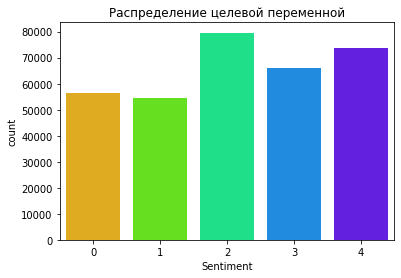

In [41]:
sns.countplot(x=oversampled_data.Sentiment, palette='gist_rainbow').set_title("Распределение целевой переменной")

In [42]:
X = vectorizer.fit_transform(oversampled_data.Phrase.values)
y = oversampled_data.Sentiment.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=21)

In [43]:
logreg = LogisticRegression(multi_class="multinomial", random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      8427
           1       0.62      0.47      0.53      8264
           2       0.64      0.74      0.68     11954
           3       0.59      0.49      0.54      9739
           4       0.78      0.84      0.81     11147

    accuracy                           0.69     49531
   macro avg       0.68      0.68      0.68     49531
weighted avg       0.68      0.69      0.68     49531



In [44]:
gb_cls = GradientBoostingClassifier(random_state=42)
gb_cls.fit(X_train, y_train)
y_pred = gb_cls.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.37      0.49      8427
           1       0.44      0.11      0.17      8264
           2       0.35      0.84      0.50     11954
           3       0.38      0.13      0.20      9739
           4       0.56      0.57      0.56     11147

    accuracy                           0.44     49531
   macro avg       0.49      0.40      0.38     49531
weighted avg       0.48      0.44      0.40     49531



In [45]:
tree = DecisionTreeClassifier(random_state=42, max_depth=7, criterion='entropy')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.21      0.28      8427
           1       0.33      0.04      0.08      8264
           2       0.27      0.92      0.42     11954
           3       0.67      0.00      0.00      9739
           4       0.51      0.19      0.28     11147

    accuracy                           0.31     49531
   macro avg       0.44      0.27      0.21     49531
weighted avg       0.44      0.31      0.23     49531



In [46]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.79      0.67      8427
           1       0.50      0.40      0.44      8264
           2       0.58      0.44      0.50     11954
           3       0.49      0.39      0.43      9739
           4       0.60      0.80      0.69     11147

    accuracy                           0.56     49531
   macro avg       0.55      0.56      0.55     49531
weighted avg       0.55      0.56      0.55     49531



# SMOTE

In [47]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [48]:
X = vectorizer.fit_transform(train.Phrase.values)
y = train.Sentiment.values

X_smote, y_smote = SMOTE().fit_resample(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.15, random_state=21)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Распределение целевой переменной')

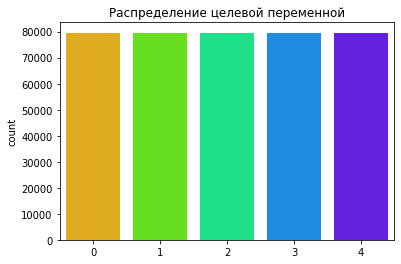

In [51]:
sns.countplot(x=y_smote,  palette='gist_rainbow').set_title("Распределение целевой переменной")

In [52]:
logreg = LogisticRegression(multi_class="multinomial", random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.72      0.70     11986
           1       0.63      0.50      0.56     11945
           2       0.43      0.55      0.48     11953
           3       0.59      0.47      0.52     11900
           4       0.70      0.75      0.73     11903

    accuracy                           0.60     59687
   macro avg       0.61      0.60      0.60     59687
weighted avg       0.61      0.60      0.60     59687



In [53]:
gb_cls = GradientBoostingClassifier(random_state=42)
gb_cls.fit(X_train, y_train)
y_pred = gb_cls.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.40      0.49     11986
           1       0.50      0.21      0.30     11945
           2       0.29      0.76      0.42     11953
           3       0.42      0.22      0.29     11900
           4       0.59      0.50      0.54     11903

    accuracy                           0.42     59687
   macro avg       0.49      0.42      0.41     59687
weighted avg       0.49      0.42      0.41     59687



In [54]:
tree = DecisionTreeClassifier(random_state=42, max_depth=7, criterion='entropy')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.11      0.19     11986
           1       0.44      0.04      0.07     11945
           2       0.21      0.97      0.35     11953
           3       0.67      0.00      0.00     11900
           4       0.63      0.14      0.23     11903

    accuracy                           0.25     59687
   macro avg       0.53      0.25      0.17     59687
weighted avg       0.53      0.25      0.17     59687



In [55]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.70      0.65     11986
           1       0.55      0.45      0.50     11945
           2       0.62      0.37      0.46     11953
           3       0.43      0.51      0.47     11900
           4       0.61      0.77      0.68     11903

    accuracy                           0.56     59687
   macro avg       0.56      0.56      0.55     59687
weighted avg       0.57      0.56      0.55     59687



# word2vec

In [56]:
from gensim.models import word2vec

In [57]:
!pip install cython

In [61]:
class TextToList:
  def __call__(self, text):
        tokens = nltk.word_tokenize(text)
        return [
            token for token in tokens
        ]

In [63]:
train["Phrase"] =  [TextToList()(x) for x in tqdm(train["Phrase"])]

In [66]:
num_features = 300    # Word vector dimensionality                      
min_word_count = 1   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3 

model = word2vec.Word2Vec(train.Phrase.values, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

In [67]:
model.most_similar("good")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('frat', 0.7747133374214172),
 ('skirt', 0.7629051804542542),
 ('reyes', 0.7603274583816528),
 ('earthly', 0.7403990626335144),
 ('sensationalize', 0.7352858781814575),
 ('caliber', 0.7283518314361572),
 ('clam', 0.7224575281143188),
 ('list', 0.7160661220550537),
 ('edit', 0.7105578184127808),
 ('idea', 0.7070690393447876)]

In [70]:
model.most_similar("excellent")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('receives', 0.9733031988143921),
 ('denzel', 0.9723120927810669),
 ('vanessa', 0.9651637077331543),
 ('washington', 0.9650337100028992),
 ('piccoli', 0.9630882143974304),
 ('redgrave', 0.9627469182014465),
 ('ferrera', 0.9613833427429199),
 ('workshop', 0.9608651995658875),
 ('ontiveros', 0.9590384364128113),
 ('enhances', 0.9577794671058655)]

# Submission

In [ ]:
X = vectorizer.transform(test.Phrase.values)
y_pred = logreg.predict(X)

submission = pd.read_csv(root_dir + 'sampleSubmission.csv', header=0, index_col='PhraseId')
submission['Sentiment'] = y_pred
submission.to_csv('submission.csv')
submission.head()